# STAT 301: Statistical Modelling for Data Science 


# <font color=red> Confounding Factors
    
## Gabriela Cohen Freue

## Case study: relation between mRNA and protein levels

The picture illustrates what is known as the Central Dogma of Biology

![](https://github.com/UBC-STAT/stat-301/blob/master/materials/worksheet_07/img/prot_gene.png?raw=true)

Despite expectations of a high correlation between mRNA and protein levels, experimental results have shown very low correlation values.

Many research groups have investigated the relation between mRNA and protein levels. 

In 2014, a research group claimed to find a "predictive model", which can be used to predict protein from mRNA!!

> Wilhelm, M. et al. Mass-spectrometry-based draft of the human proteome. Nature 509, 582–587 (2014)

> Paper from my research group: Fortelny N, Overall CM, Pavlidis P, Freue GVC. Can we predict protein from mRNA levels? Nature. 2017 Jul 26;547(7664):E19-E20. doi: 10.1038/nature22293.

We'll use data from this group submitted to the Journal to examine this problem

### Claim

Using the median ratio of protein to mRNA levels per gene as a proxy for translation rates, our data show that [...] ***it now becomes possible to predict protein abundance in any given tissue with good accuracy from the measured mRNA abundance***

![](https://github.com/UBC-STAT/stat-301/blob/master/materials/worksheet_07/img/nature_res.png?raw=true)

## Paper's model and estimation

In the paper, the authors used a linear regression to estimate the relation between protein and mRNA levels *per gene*, and used that model to predict protein levels *per gene*.

> it will be important at a later phase of the analysis to note that models are *gene-specific*

**Gene-specific models**: for each gene they estimated the following model (for simplicity we do not use a subscript $g$)  

$$\text{prot}_{t} = \beta_1 \; \times \text{mrna}_{t} + \varepsilon_t$$ 

where $\hat{\beta}_1 = median_t(\text{prot}_{t}/\text{mrna}_{t})$

> prot$_{t}$ and mrna$_{t}$ are the protein and mRNA levels of a gene $g$ in tissue $t$, respectively

<font color="blue"> **Note that these models do not contain an intercept! and they were not estimated by LS.**</font> 
    
While in general different models and estimation methods can be used to analyze the same data, it is important to evaluate the results according to the assumptions and the methodology used. 
    
> The evaluation and interpretation of the results in the paper were not appropriate
    
*Let's take a look at the data.*

In [5]:
library(tidyverse)
library(ggplot2)
library(broom)

dat_sel <-read.csv("nature_dat.csv", row.names = 1, stringsAsFactors=TRUE)

## PART I: data wrangling

**Note**: If you want to run the cells of Part I, you need to copy the "data" directory in the same directory where you store this JN

Otherwise, just run the cell above to import the clean dataset.

In [13]:
prot <- data.matrix(read.csv("data/proteinUN.csv", row.names = 1))
mrna <- data.matrix(read.csv("data/geneUN.csv", row.names = 1))
tissues <- colnames(mrna)
genes <- proteins <-rownames(prot)

#### A quick glance at the data:

Protein and mRNA values were measured for 6104 genes on 12 different tissues. Data are stored in `prot` and `mrna` datasets, respectively. 

In [2]:
dim(prot)
dim(mrna)
length(tissues)

head(prot,3)
head(mrna,3)

[1] 6104   12

[1] 6104   12

[1] 12

,uterus,kidney,testis,pancreas,stomach,prostate,ovary,thyroid.gland,adrenal.gland,salivary.gland,spleen,esophagus
ENSG00000000003,NA,NA,NA,NA,9.157831e-07,NA,NA,NA,NA,9.027262e-06,NA,NA
ENSG00000000419,9.966484e-06,1.894265e-05,4.257907e-05,1.575567e-06,3.282342e-05,2.119753e-05,3.916784e-05,3.930635e-06,1.016500e-05,4.048574e-05,5.092213e-06,1.607405e-05
ENSG00000000457,NA,NA,6.752985e-07,4.704207e-07,3.745549e-06,NA,NA,NA,3.059918e-07,7.894253e-06,NA,NA


,uterus,kidney,testis,pancreas,stomach,prostate,ovary,thyroid.gland,adrenal.gland,salivary.gland,spleen,esophagus
ENSG00000000003,2.50e-05,4.44e-05,5.79e-05,1.43e-05,2.01e-05,3.04e-05,5.60e-05,3.04e-05,2.16e-05,5.58e-05,9.90e-06,4.76e-05
ENSG00000000419,3.44e-05,3.43e-05,3.80e-05,2.11e-05,2.96e-05,3.40e-05,3.17e-05,4.54e-05,5.01e-05,2.44e-05,2.96e-05,4.28e-05
ENSG00000000457,7.80e-06,6.80e-06,7.60e-06,4.10e-06,7.70e-06,8.60e-06,8.20e-06,8.20e-06,6.60e-06,6.50e-06,7.40e-06,7.20e-06


The following cell contains some data wrangling code to count the number of missing values and select only those genes at least 2 proein measurements (genomics data is complete). 

> Note: We can also focus genes with complete or more observations for more relevant results.

In [3]:
#counting missing values
values.av <- sapply(genes, function(p){
  return(sum(!is.na(prot[p,]) & !is.na(mrna[p,])))
})
names(values.av) <- genes

#delete proteins with less than 3 values available
prot_sel <- data.frame(prot,gene=rownames(prot))  %>% mutate(values.av = values.av)  %>% 
        filter(values.av > 2)

#keep the same subset of genes in the mRNA dataset
mrna_sel <- data.frame(mrna,gene=rownames(mrna))  %>% filter(gene %in% prot_sel$gene)

head(prot_sel,3)
head(mrna_sel,3)

,uterus,kidney,testis,pancreas,stomach,prostate,ovary,thyroid.gland,adrenal.gland,salivary.gland,spleen,esophagus,gene,values.av
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
ENSG00000000419,9.966484e-06,1.894265e-05,4.257907e-05,1.575567e-06,3.282342e-05,2.119753e-05,3.916784e-05,3.930635e-06,1.016500e-05,4.048574e-05,5.092213e-06,1.607405e-05,ENSG00000000419,12
ENSG00000000457,NA,NA,6.752985e-07,4.704207e-07,3.745549e-06,NA,NA,NA,3.059918e-07,7.894253e-06,NA,NA,ENSG00000000457,5
ENSG00000000971,3.633516e-05,3.358335e-04,1.848077e-04,2.956261e-04,1.561922e-04,1.848922e-04,2.033825e-04,7.749283e-05,1.049859e-04,1.306766e-04,1.150577e-04,5.391352e-04,ENSG00000000971,12


,uterus,kidney,testis,pancreas,stomach,prostate,ovary,thyroid.gland,adrenal.gland,salivary.gland,spleen,esophagus,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000000419,3.44e-05,3.43e-05,3.80e-05,2.11e-05,2.96e-05,3.40e-05,3.17e-05,4.54e-05,5.01e-05,2.44e-05,2.96e-05,4.28e-05,ENSG00000000419
ENSG00000000457,7.80e-06,6.80e-06,7.60e-06,4.10e-06,7.70e-06,8.60e-06,8.20e-06,8.20e-06,6.60e-06,6.50e-06,7.40e-06,7.20e-06,ENSG00000000457
ENSG00000000971,1.42e-05,1.93e-05,1.89e-05,6.90e-06,4.71e-05,2.42e-05,2.42e-05,3.31e-05,4.53e-05,2.23e-05,1.14e-05,6.76e-05,ENSG00000000971


We now merge the proteomic and genomic datasets 

> Note that the function `gather` is used to change the format of both datasets to "long". Then `full_join` is used to merge both datasets.

In [4]:
prot_long <- gather(prot_sel, tissue, prot, uterus:esophagus, factor_key=TRUE)
mrna_long <- gather(mrna_sel, tissue, mrna, uterus:esophagus, factor_key=TRUE)

dat_sel <- prot_long  %>%  full_join(mrna_long, by = c("gene","tissue")) %>% 
             mutate(gene=as.factor(gene)) 
head(dat_sel,3)

,gene,values.av,tissue,prot,mrna
,<fct>,<int>,<fct>,<dbl>,<dbl>
1,ENSG00000000419,12,uterus,9.966484e-06,3.44e-05
2,ENSG00000000457,5,uterus,NA,7.80e-06
3,ENSG00000000971,12,uterus,3.633516e-05,1.42e-05


In [5]:
str(dat_sel)

'data.frame':	57888 obs. of  5 variables:
 $ gene     : Factor w/ 4824 levels "ENSG00000000419",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ values.av: int  12 5 12 7 12 7 9 12 7 7 ...
 $ tissue   : Factor w/ 12 levels "uterus","kidney",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ prot     : num  9.97e-06 NA 3.63e-05 1.68e-05 1.69e-05 ...
 $ mrna     : num  3.44e-05 7.80e-06 1.42e-05 3.46e-05 1.92e-05 ...


The resulting dataset is saved as a .csv file for future use.

In [6]:
#write.csv(dat_sel, "data/nature_dat.csv", row.names = TRUE)

### Predicted values

We now add (in-sample) predictions using the 2 methods mentioned above to estimate the gene-specific models:

- median-ratios to estimate the slopes, no intercept, of each gene-specific model (used in the paper)

- LS to estimate the intercept and the slope of each gene-specific model (learned in this course)

In [6]:
#adding predictions to data 

#median-ratios
rr <- dat_sel  %>% mutate(ratio=prot/mrna)  %>% group_by(gene)  %>% 
    summarize(ratio_g=median(ratio,na.rm =  TRUE),se_ratio=1.25*sd(ratio,na.rm=TRUE)/sqrt(length(ratio)))

dat_ratio <- dat_sel %>% full_join(rr, by= "gene") %>% mutate(.fitted_ratio=mrna*ratio_g)

#LS
dat_ls <- dat_sel %>%  group_by(gene) %>%
  do(augment(lm(prot ~ mrna, data = .)))  

In [7]:
head(dat_ratio,3)

,gene,tissue,prot,mrna,ratio_g,se_ratio,.fitted_ratio
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000419,uterus,9.966484e-06,3.44e-05,0.4639129,0.1908848,1.595860e-05
2,ENSG00000000971,uterus,3.633516e-05,1.42e-05,7.8077724,4.0426137,1.108704e-04
3,ENSG00000001084,uterus,1.693588e-05,1.92e-05,1.8385043,0.5528411,3.529928e-05


In [8]:
head(dat_ls, 3)

gene,prot,mrna,.fitted,.resid,.hat,.sigma,.cooksd,.std.resid
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000419,9.966484e-06,3.44e-05,2.024583e-05,-1.027934e-05,0.08339345,1.590533e-05,0.0219224062,-0.69420001
ENSG00000000419,1.894265e-05,3.43e-05,2.028235e-05,-1.339703e-06,0.08346175,1.629634e-05,0.0003727307,-0.09047824
ENSG00000000419,4.257907e-05,3.80e-05,1.893084e-05,2.364822e-05,0.09799243,1.403211e-05,0.1407864482,1.60991986


## PART II: Analysis and Results 

Last class we learned that the coefficient of determination, $R^2$, can be used to assess the goodness of the fit of the model by comparing to that of an intercept-only model (or average of the response).

> Note: this quantity should be used with caution for the model and estimation method suggested in the Nature's paper, since many of its properties are not longer true for those.

In [9]:
#R-sq from LS analyses

rsq_ls <- dat_sel %>%  group_by(gene) %>%
  do(glance(lm(prot ~ mrna, data = .))) %>% drop_na(sigma) %>% 
  select(gene, r.squared)

In [10]:
hist_ls_r2 <- ggplot(rsq_ls, aes(x=r.squared)) + geom_histogram(color="navy") + 
  theme_bw(24) + xlab("Rsq per gene for LS-estimated models") + ylab("Count") + xlim(-1, 1)+
  geom_vline(xintercept=median(rsq_ls$r.squared, na.rm=T),color="red")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


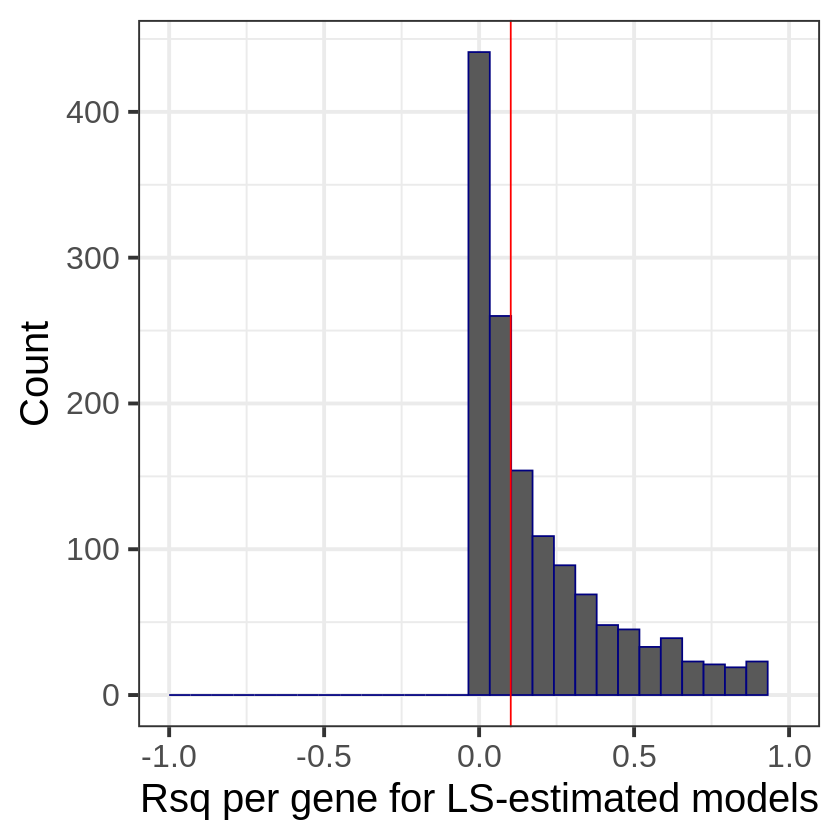

In [11]:
hist_ls_r2

These results suggest that the quality of the proposed models vary greatly across genes. In other words, for some genes, a SLR with mRNA as input variable is a good model to fit the data. However, for the majority of the genes, their model do not fit the data well. 

> But the conclusions of the Nature paper are different. 

Let's try to understand point-by-point what has been done:

### Analysis

- Many (around 4824) *gene-specific* models were estimated

    - each gene was analyzed separately, as an independent dataset
    
    - tissues were used to collect a sample (they are observations, not values of a variable) 

- To assess the prediction performance of the proposed models, the authors of the Nature paper reported **the correlation** between the observed and the predicted protein for ***all*** genes ***per*** tissue.

    - predictions of different models are all mixed
    
    - protein abundance varies greatly among genes so mixing them obscures the performance of *each gene-specific* model!
    
    - results are examined per observation (tissues)!! 

> **Why the correlation?**: the correlation is a measurement commonly used to check the proximity of 2 variables. If $y_i$ is close to $\hat{y}_i$, then points should be over the 45 degree line of a scatter plot. 

- As a side point, we note that although the authors of the Nature paper wanted to build a strong predictive model, they did not analyze out-of-sample predictions. 

### Plot 

#### Ignoring gene-effects and looking at salivary gland for all genes

In [13]:
dat_sal <- dat_ratio  %>% filter(tissue=="salivary.gland")
r_sal <- dat_sal  %>% summarize(r=cor(prot,.fitted_ratio,use="complete.obs",method="spearman"))     

Warning message:
“Removed 840 rows containing non-finite values (stat_ellipse).”
Warning message:
“Removed 840 rows containing missing values (geom_point).”


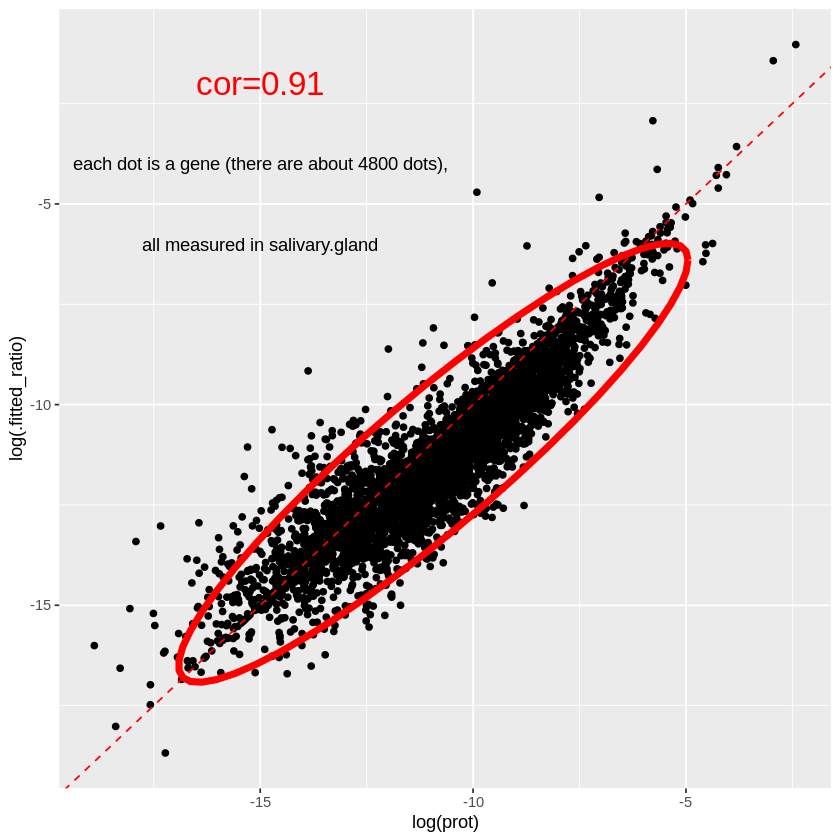

In [14]:
conf_plot_sg <- ggplot(dat_sal,aes(log(prot),log(.fitted_ratio)))+
           geom_point() +
            geom_abline(intercept=0,slope=1,color="red",linetype="dashed") +
            annotate(geom="text", x=-15, y=-2, label="cor=0.91", size =7, color="red")+
            annotate(geom="text", x=-15, y=-6, label="all measured in salivary.gland")+
annotate(geom="text", x=-15, y=-4, label="each dot is a gene (there are about 4800 dots),")+
           stat_ellipse(level=0.99,size=2,color="red")
conf_plot_sg

#### Observations

- Note that this plot *does not* illustrate the performance of the analysis! It shows **only 1 of the 12** observations used in each gene-specific model (observed and predicted protein values for salivary-gland)

- the correlation can be large, even when some points (genes) are *far* from the diagonal!! 

    - "far" means: not a good prediction
    
    - **Important**: it seems that for some genes the prediction is good but for others is not. 
    
    >Results were mixed when looking at all genes together!

- <font color="blue">**Stem of the problem**: the correlation is driven by the large (dynamic) range in protein values, which is well known characteristic of protein data</font>

## Discussion

### Confounding 

The authors did not evaluate their *gene-specific* models. Results *per gene* are quite different!

A simpler plot with less genes shows that the relation between the observed and the predicted ($y$ and $\hat{y}$, respectively) protein levels varies much by gene!!
 
 - for some genes the points are tighly around the line
 
 - for others, they are very disperse indicating that the predicted values are not similar to the observed ones

Let's focus on only some genes with complete measurements (i.e., 12 observations, without missing values) some with strong and some with weak correlations between the observed and the predicted values. 

Recall: 

> For our LS estimated models: the correlation between observed and predicted values is equivalent to the coefficient of determination

$$\text{cor}(\textbf{prot}, \hat{\textbf{prot}}) = R^2$$

> While this is not true for the original analysis, for simplicity, we will use the $R^2$ as an approximated measure of strength to select 3 genes

In [15]:
# Selecting genes with different predictive results

gene_12 <- values.av[values.av ==12]
dat_12 <- rsq_ls  %>% filter(gene %in% names(gene_12))  

g1 <- dat_12  %>% subset(r.squared < 10^(-06))
g2 <- dat_12  %>% filter(r.squared < 0.6 && r.squared > 0.595)

dg1<-dat_ratio %>% filter(gene %in% g1$gene)
dg2<-dat_ratio %>% filter(gene %in% g2$gene)
dg3<-dat_ratio %>% filter(gene =="ENSG00000116791")

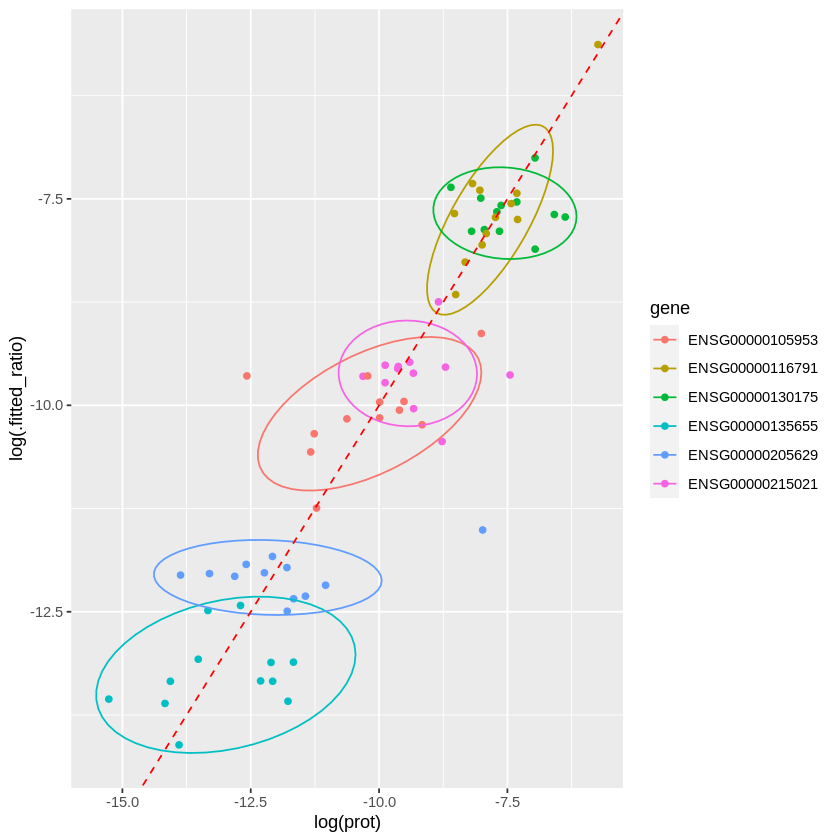

In [16]:
#Plot of all data for the 6 selected genes, colored by genes

dat_plot <-rbind(dg1,dg2,dg3)
conf_plot_g <- ggplot(dat_plot,aes(log(prot),log(.fitted_ratio),color=gene))+
            geom_point() + stat_ellipse(level=0.9)+
            geom_abline(intercept=0,slope=1,color="red",linetype="dashed")
conf_plot_g

#### A different (confounded) perception!

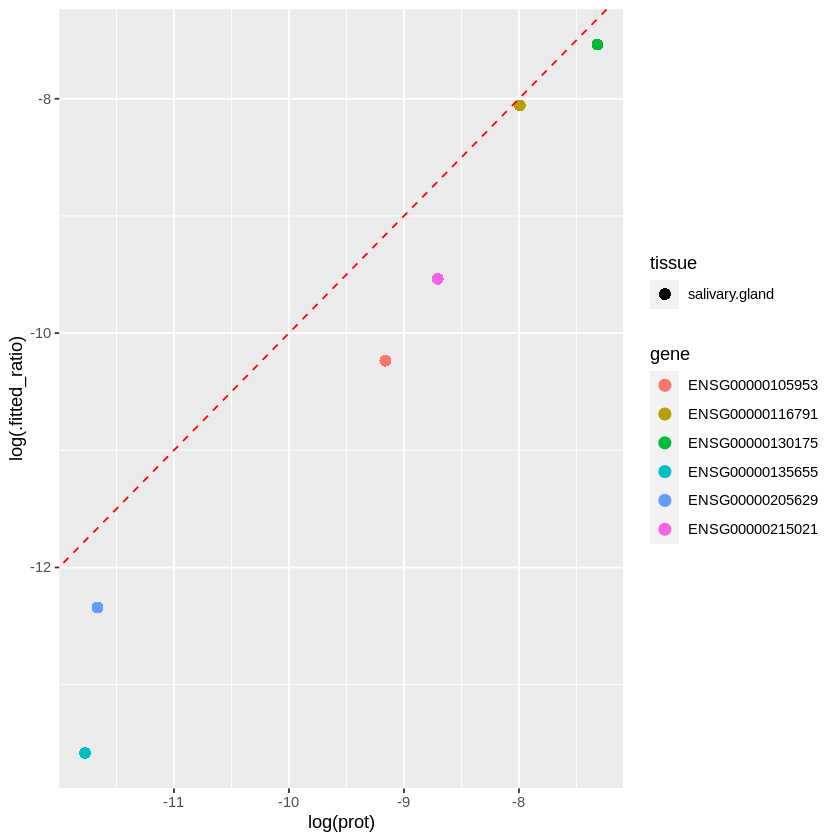

In [17]:
dat_plot <-rbind(dg1,dg2,dg3)
dat_sal <- dat_plot  %>% filter(tissue=="salivary.gland")
tissue_plot_g <- ggplot(dat_sal,aes(log(prot),log(.fitted_ratio),color=gene,shape=tissue))+
            geom_point(size=3) +
            geom_abline(intercept=0,slope=1,color="red",linetype="dashed")
tissue_plot_g

#### A correlation analysis *per-tissue* ignores the gene-to-gene variation. Thus, their analysis is *confounded*!! 

In this analysis, the categorical variable, `gene`, is the confounding factor!

- `gene` is related with protein values (`prot`) 

    - protein values vary greatly among genes

***and***

- `gene` is related with the predicted values (`.fitted_ratio`) 

     - predicted values were obtained *per gene* 

Although the variable `gene` was not implicitly used in the analysis of the paper, we showed that gene-specific slopes can be obtained with a model *with* interactions instead of different gene-specific models. 

> recall exercise in tutorial_03: equal estimates but different SEs

### The MSE 

The authors could have used the MSE as a measured of prediction performance. That measure is not driven by protein range as the correlation.

In our study, we compared the training (and test) MSE of their estimated model versus that of a null model (without mRNA). For many genes (about half) the proposed model does not predict better than the null 

> below is the image of the training MSE, similar results were found for the test MSE)

In [21]:
pmse <- dat_ratio  %>% group_by(gene)  %>% 
        summarize(mse_ratio=mean(res_ratio^2,rm.na=TRUE), mse_0=mean((prot-mean(prot))^2,,rm.na=TRUE))  %>% 
        drop_na(mse_ratio)  %>% mutate(better_null=(mse_0<=mse_ratio))
pmse_long <- gather(pmse, method, mse, mse_ratio:mse_0, factor_key=TRUE)

Warning message:
“Removed 442 rows containing missing values (geom_point).”


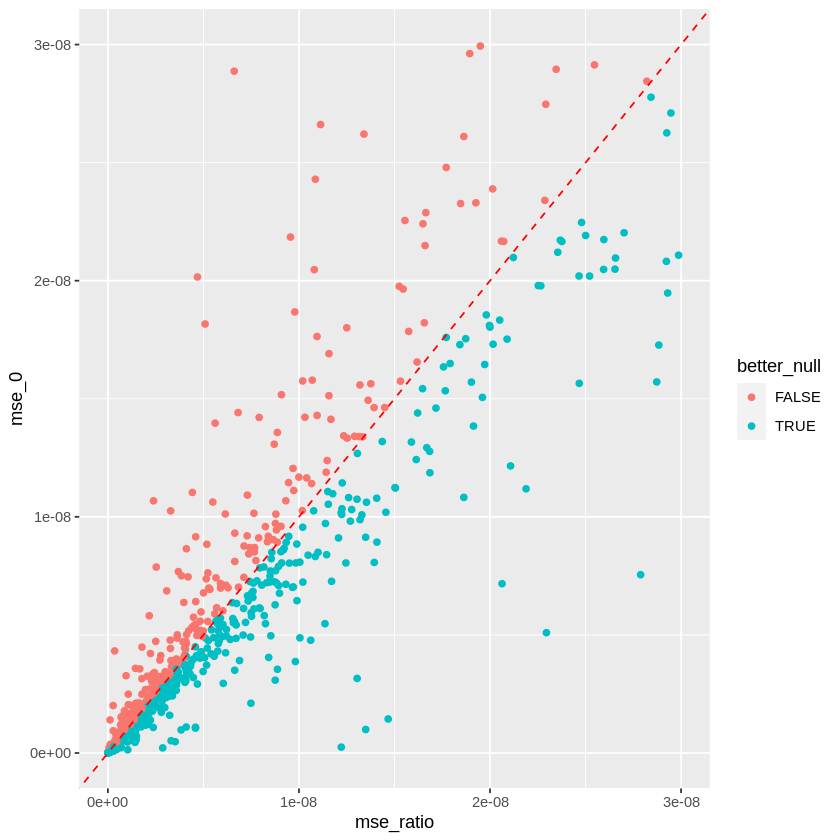

In [25]:
mse_comparison <- ggplot(pmse, aes(x=mse_ratio, y=mse_0,color=better_null)) + xlim(0,3e-08)+ ylim(0,3e-08)+
  geom_point() +
  geom_abline(intercept=0,slope=1,color="red",linetype="dashed")

mse_comparison

<font color="blue"> **For many genes (about half) the proposed model with mRNA as an input variable does not predict better than the intercept-only model (without mRNA)**</font>

## PART III: Negative $R^2$

In [18]:
dat_ratio <- dat_ratio %>% 
    group_by(gene) %>% mutate(res_ratio= (prot - .fitted_ratio))

rsq_ratio <- dat_ratio %>%
    group_by(gene) %>% 
    mutate(r.squared_ratio = 1- sum(res_ratio^2)/(sd(prot)^2*(values.av-1)))

head(rsq_ratio,3)
head(dat_ratio,3)

gene,values.av,tissue,prot,mrna,ratio_g,se_ratio,.fitted_ratio,res_ratio,r.squared_ratio
<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000419,12,uterus,9.966484e-06,3.44e-05,0.4639129,0.1908848,1.595860e-05,-5.992118e-06,-0.2544457
ENSG00000000457,5,uterus,NA,7.80e-06,0.1147367,0.1780286,8.949466e-07,NA,NA
ENSG00000000971,12,uterus,3.633516e-05,1.42e-05,7.8077724,4.0426137,1.108704e-04,-7.453521e-05,-0.1646294


gene,values.av,tissue,prot,mrna,ratio_g,se_ratio,.fitted_ratio,res_ratio
<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000419,12,uterus,9.966484e-06,3.44e-05,0.4639129,0.1908848,1.595860e-05,-5.992118e-06
ENSG00000000457,5,uterus,NA,7.80e-06,0.1147367,0.1780286,8.949466e-07,NA
ENSG00000000971,12,uterus,3.633516e-05,1.42e-05,7.8077724,4.0426137,1.108704e-04,-7.453521e-05


In [19]:
hist_ratio_r2 <- ggplot(rsq_ratio, aes(x=r.squared_ratio)) + geom_histogram(color="navy") + 
  theme_bw(24) + xlab("Rsq per gene for LS-estimated models") + ylab("Count") + xlim(-1, 1)+
  geom_vline(xintercept=median(rsq_ratio$r.squared_ratio, na.rm=T),color="red")

#### Note the negative values!!

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 42420 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


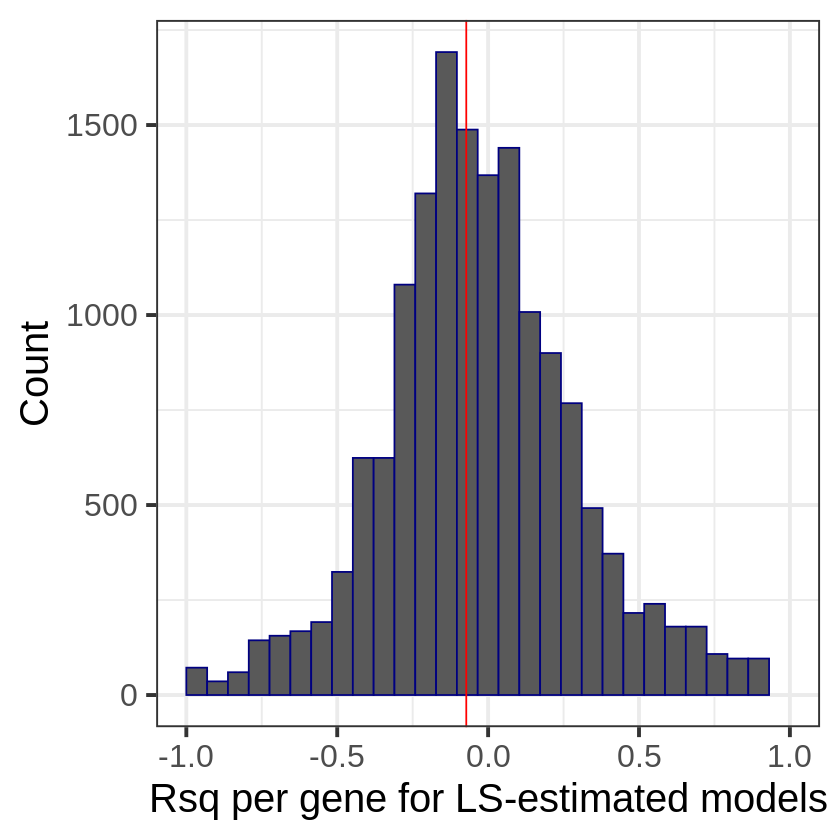

In [20]:
hist_ratio_r2

#### Regression through the origin (no intercept)

- The LS residuals no longer have a zero sample average


- A consequence of this is that the classical coefficient of determination, defined as $R^2=1-\frac{RSS}{TSS}$, can be negative


- If the model does not have an intercept, we can use the squared correlation coefficient between the actual and fitted values of $Y$

    > the authors reported a correlation but not the correct one
    
    > they correlated the predicted vs the observed protein levels *across* genes, confounding the results


- Should we add an intercept? 

    - Estimating an intercept when it is truly zero (in the population) inflates the variances of the LS slope estimators, which results in larger p-values for the slopes
    
    - But if the intercept in the population model is truly different from zero, then the LS estimators of the slope parameters will be biased unless an intercept is included in the LR

# Additional information:

- [Simpson's Paradox gif from Prof Irizarry](https://simplystatistics.org/2017/08/08/code-for-my-educational-gifs/)

- [Shiny app for Nature's models (by my research group)](https://dakep.shinyapps.io/central-dogma/)

### Conclusions

- The performance *within* genes is not the same as that *across* genes

- Ignoring `gene` in the *across* genes analysis confounds the results of the study and their conclusions

- Confounding can be addressed by adding the variable `gene` in the model 

> If you want to try, I suggest you to play with the smaller list of genes used above. 

- In our paper, we showed that: 

    - after controlling for `gene`, there's no evidence that mRNA contributes significantly to explain the variation in protein levels
    
    - there measure of prediction performance was confounded
    
    - predicting protein with the mean (or median) protein value (intercept-only model) and using *their* prediction performance measure **also** gives large correlations. The problem was the way performance was evaluated
    
    - predicting protein with mRNA values of random genes and using *their* prediction performance measure **also** gives large correlations. The problem was the way performance was evaluated